In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv("../data/Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Data understanding and Exploration

In [7]:
df.drop(columns=['RowNumber'], inplace=True)

In [8]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [10]:
df.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [11]:
df.shape

(10000, 13)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [13]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [15]:
df.nunique()

CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [16]:
# Identify churn column (robust to common names)
possible = ['Exited','Churn','churn','is_churn','IsChurn']
churn_col = next((c for c in possible if c in df.columns), None)
if churn_col is None:
    raise KeyError('Could not find churn column; expected one of: ' + str(possible))
print('Using churn column:', churn_col)

Using churn column: Exited


In [17]:
# Class imbalance and churn rate
vc = df[churn_col].value_counts(dropna=False).to_frame('count')
vc['pct'] = vc['count'] / vc['count'].sum() * 100
display(vc)
print('\nChurn rate (positive class assumed to be 1):')
if set(df[churn_col].unique()) <= {0,1}:
    print(df[churn_col].mean())
else:
    try:
        print((df[churn_col] == df[churn_col].unique()[0]).mean())
    except Exception:
        pass

,count,pct
Exited,,
0,7963,79.63
1,2037,20.37



Churn rate (positive class assumed to be 1):
0.2037


## Visual EDA: churn vs geography, tenure, and balance/estimated salary

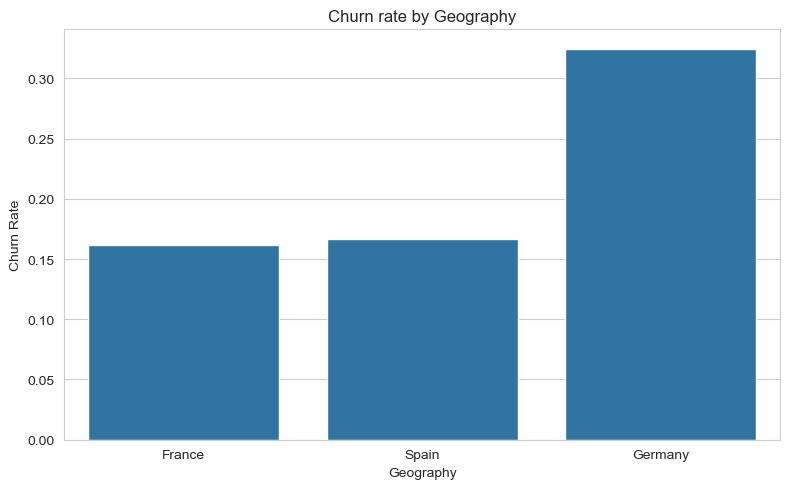

In [18]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
if 'Geography' in df.columns:
    geo = df.groupby('Geography')[churn_col].mean().sort_values()
    sns.barplot(x=geo.index, y=geo.values)
    plt.ylabel('Churn Rate')
    plt.title('Churn rate by Geography')
else:
    print('No Geography column found; skipping geography plot')
plt.tight_layout()

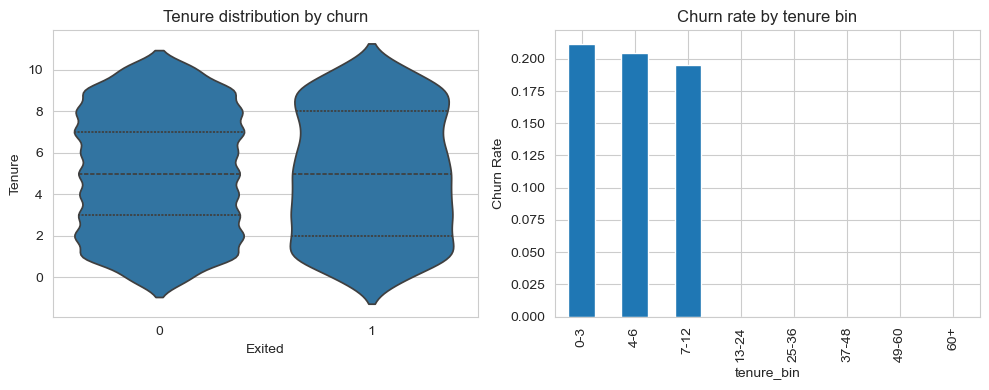

In [19]:
# Churn vs Tenure: violin + churn rate by tenure buckets
plt.figure(figsize=(10,4))
if 'Tenure' in df.columns:
    plt.subplot(1,2,1)
    sns.violinplot(x=churn_col, y='Tenure', data=df, inner='quartile')
    plt.title('Tenure distribution by churn')
    plt.subplot(1,2,2)
    df['tenure_bin'] = pd.cut(df['Tenure'], bins=[-1,3,6,12,24,36,48,60,100], labels=['0-3','4-6','7-12','13-24','25-36','37-48','49-60','60+'])
    tenure_rate = df.groupby('tenure_bin')[churn_col].mean()
    tenure_rate.plot(kind='bar')
    plt.ylabel('Churn Rate')
    plt.title('Churn rate by tenure bin')
else:
    print('No Tenure column found; skipping tenure plots')
plt.tight_layout()

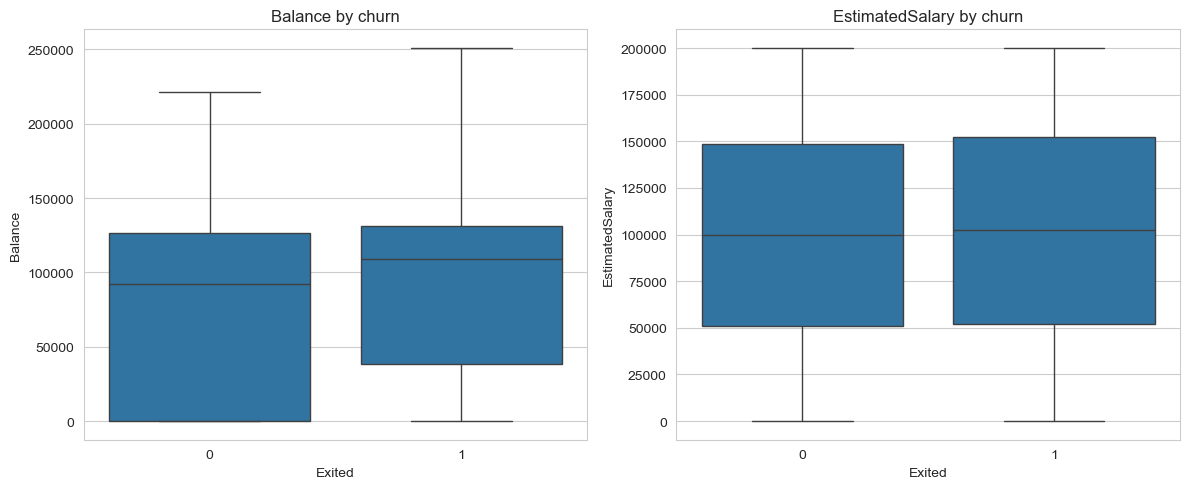

In [20]:
# Churn vs Balance / EstimatedSalary (proxies for monthly charges)
plt.figure(figsize=(12,5))
cols = [c for c in ['Balance','EstimatedSalary'] if c in df.columns]
if cols:
    for i,c in enumerate(cols,1):
        plt.subplot(1,len(cols),i)
        sns.boxplot(x=churn_col, y=c, data=df)
        plt.title(f'{c} by churn')
else:
    print('No Balance/EstimatedSalary columns found; skipping financial plots')
plt.tight_layout()

## Correlation heatmap (numeric features)

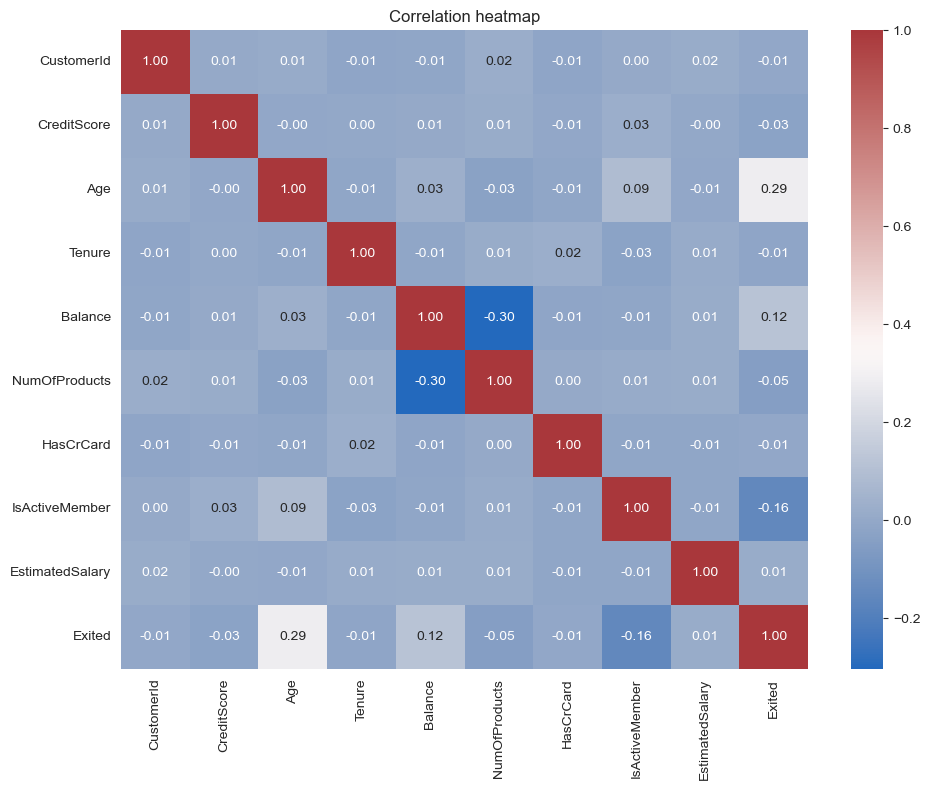

In [21]:
num = df.select_dtypes(include=[np.number])
if churn_col not in num.columns and df[churn_col].dtype == 'object':
    try:
        num[churn_col] = pd.to_numeric(df[churn_col], errors='coerce')
    except Exception:
        pass
plt.figure(figsize=(10,8))
corr = num.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag')
plt.title('Correlation heatmap')
plt.tight_layout()

## Segment churners vs non-churners visually

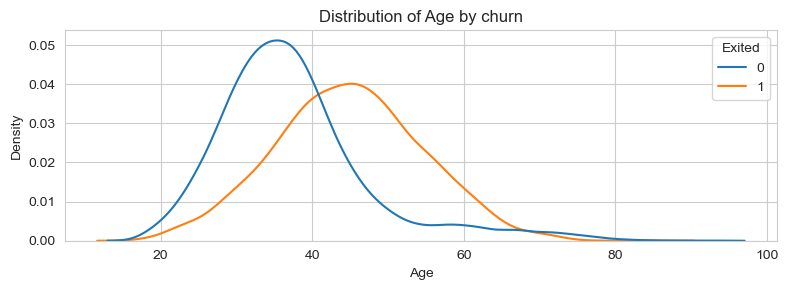

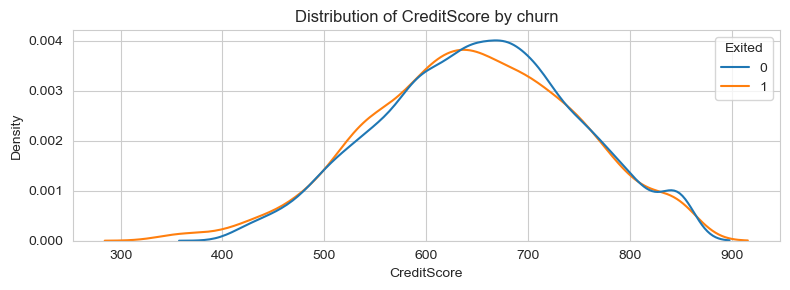

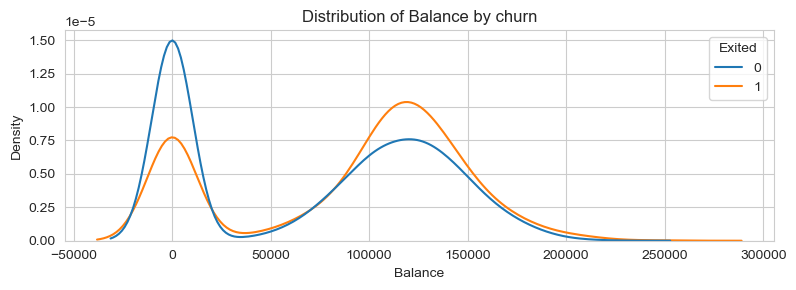

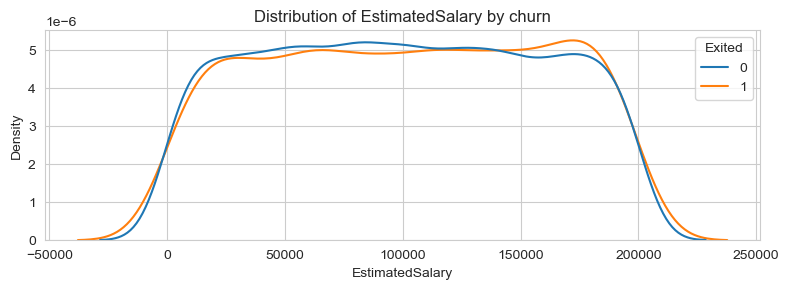

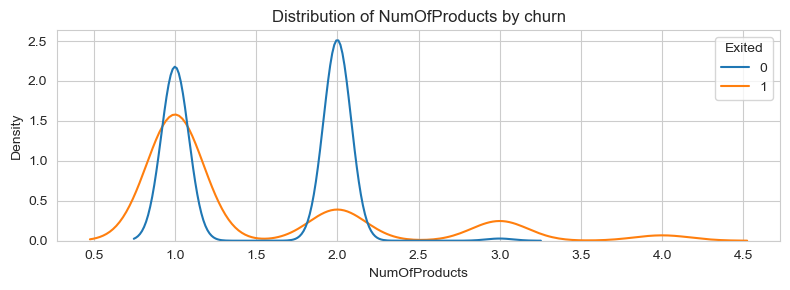

In [22]:
# Plot distributions for a few key numeric features side-by-side
features = [f for f in ['Age','CreditScore','Balance','EstimatedSalary','NumOfProducts'] if f in df.columns]
if features:
    for f in features:
        plt.figure(figsize=(8,3))
        sns.kdeplot(data=df, x=f, hue=churn_col, common_norm=False)
        plt.title(f'Distribution of {f} by churn')
        plt.tight_layout()
else:
    print('No chosen numeric features found for segmentation plots')

## Early-stage churn behavior

In [23]:
# Fraction of churners within first 3 and 6 months (if Tenure exists)
if 'Tenure' in df.columns:
    for limit in [3,6]:
        subset = df[df['Tenure'] <= limit]
        if len(subset):
            print(f'Churn rate within {limit} months: {subset[churn_col].mean():.4f} ({len(subset)} customers)')
else:
    print('No Tenure column to evaluate early-stage churn')

Churn rate within 3 months: 0.2114 (3505 customers)
Churn rate within 6 months: 0.2084 (6473 customers)
